# Market-Basket Analysis with Spark

Market Basket Analysis (MBA) is a technique used by large retailers to discover associations between their items.

It works by looking for combinations of items that are bought together frequently, providing information to understand the purchase behavior. 

In this lecture, we will perform an exploratory analysis on a real Instacart Dataset of 3M+ records and implement market basket analysis using the Apache Spark MLlib FP-growth algorithm.


Let's install pyspark (if needed) and import the required libraries.

In [ ]:
!pip install pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

     |████████████████████████████████| 212.3MB 63kB/s 
     |████████████████████████████████| 204kB 17.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=649339e4b9562fe3af6d55d7e8fd4acc923c521e2c00c0bd8ac0a686d5cc2da6
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


We initialize a Sparksession object to run SQL queries with the method `getOrCreate()`.

We enable the Hive support with `enableHiveSupport()` to handle database views with Spark.

In [ ]:
spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Importing data

We will use “The Instacart Online Grocery Shopping Dataset 2017” (https://www.kaggle.com/c/instacart-market-basket-analysis/overview)

This anonymized dataset contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.

For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders.

Importing all the available files into the spark dataframe and creating temporary tables.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

base_path = "/content/drive/MyDrive/market_basket_analysis/"

aisles = spark.read.csv(base_path + "aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv(base_path + "departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv(base_path + "order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv(base_path + "order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv(base_path + "orders.csv", header=True, inferSchema=True)
products = spark.read.csv(base_path + "products.csv", header=True, inferSchema=True)

Mounted at /content/drive


Often we might want to store the spark Data frame as the table and query it.

To convert Data frame into temporary view that is available for only that spark session, we use `createOrReplaceTempView()` (Spark > = 2.0) on our spark Dataframe.

The method `createOrReplaceTempView()` store the table for a particular spark session. It creates (or replaces if that view name already exists) a lazily evaluated view that you can then use with Spark SQL. It does not persist to memory unless you cache the dataset that underpins the view.

In [ ]:
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

# Exploratory analysis

Let’s take a look at the top 5 rows of each of the imported file.

`orders` tells to which set (prior, train, test) an order belongs (the dataset was originally designed for a challenge).

`order_dow` is the day of week.

In [ ]:
orders.show(n = 5)

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|                7|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 5 rows



Top 5 records in the products dataframe.

In [ ]:
products.show(n = 5)

+----------+--------------------+--------+-------------+
|product_id|        product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
|         1|Chocolate Sandwic...|      61|           19|
|         2|    All-Seasons Salt|     104|           13|
|         3|Robust Golden Uns...|      94|            7|
|         4|Smart Ones Classi...|      38|            1|
|         5|Green Chile Anyti...|       5|           13|
+----------+--------------------+--------+-------------+
only showing top 5 rows



These files specify which products were purchased in each order. 

The field `reordered` indicates if the customer has a previous order that contains the product. Note that some orders will have no reordered items.

In [ ]:
order_products_train.show(n = 5)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
+--------+----------+-----------------+---------+
only showing top 5 rows



The dataframe `order_products__prior` contains previous order contents for all customers.

In [ ]:
order_products_prior.show(n = 5)

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
|       2|      9327|                3|        0|
|       2|     45918|                4|        1|
|       2|     30035|                5|        0|
+--------+----------+-----------------+---------+
only showing top 5 rows



Top 5 records in the departments dataframe.

In [ ]:
departments.show(n = 5)

+-------------+----------+
|department_id|department|
+-------------+----------+
|            1|    frozen|
|            2|     other|
|            3|    bakery|
|            4|   produce|
|            5|   alcohol|
+-------------+----------+
only showing top 5 rows



Top 5 records in the aisles dataframe.

In [ ]:
aisles.show(n = 5)

+--------+--------------------+
|aisle_id|               aisle|
+--------+--------------------+
|       1|prepared soups sa...|
|       2|   specialty cheeses|
|       3| energy granola bars|
|       4|       instant foods|
|       5|marinades meat pr...|
+--------+--------------------+
only showing top 5 rows



## On which day of the week customers purchase the most?

We perform the first query.

To perform a query we use the `sql()` method which takes a string query as argument.

To show the outcome of the query we use the `show()`  method.

In [ ]:
query = """SELECT COUNT(order_id) AS total_orders, 
             (CASE 
                WHEN order_dow = '0' THEN 'Sunday'
                WHEN order_dow = '1' THEN 'Monday'
                WHEN order_dow = '2' THEN 'Tuesday'
                WHEN order_dow = '3' THEN 'Wednesday'
                WHEN order_dow = '4' THEN 'Thursday'
                WHEN order_dow = '5' THEN 'Friday'
                WHEN order_dow = '6' THEN 'Saturday'              
              END) AS day_of_week 
           FROM orders  
           GROUP BY order_dow 
           ORDER BY total_orders DESC"""

res = spark.sql(query)
res.show()

+------------+-----------+
|total_orders|day_of_week|
+------------+-----------+
|      600905|     Sunday|
|      587478|     Monday|
|      467260|    Tuesday|
|      453368|     Friday|
|      448761|   Saturday|
|      436972|  Wednesday|
|      426339|   Thursday|
+------------+-----------+



PySpark DataFrame provides a method `toPandas()` to convert a PySpark DataFrame into a Pandas DataFrame.

By using `toPandas()`, we can use all the Pandas methods, and for instance we can plot the results with Seaborn (which takes as argument a Pandas DataFrame).

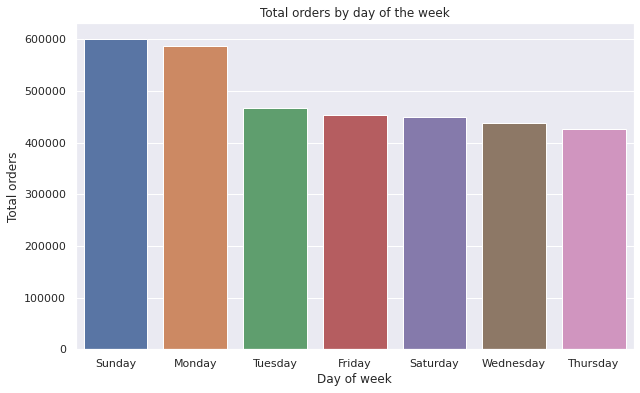

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(10,6)})
ax = sns.barplot(x = "day_of_week", y = "total_orders", data = res.toPandas())
ax.set(title = "Total orders by day of the week", xlabel = "Day of week", ylabel = "Total orders");

▶ Sunday and Monday have the most orders, while Thursday has the least orders in a week.

## What time of day do customers purchase?

In [ ]:
query = """SELECT COUNT(order_id) AS total_orders, order_hour_of_day AS hour 
           FROM orders 
           GROUP BY order_hour_of_day 
           ORDER BY order_hour_of_day"""

res = spark.sql(query)
res.show()

+------------+----+
|total_orders|hour|
+------------+----+
|       22758|   0|
|       12398|   1|
|        7539|   2|
|        5474|   3|
|        5527|   4|
|        9569|   5|
|       30529|   6|
|       91868|   7|
|      178201|   8|
|      257812|   9|
|      288418|  10|
|      284728|  11|
|      272841|  12|
|      277999|  13|
|      283042|  14|
|      283639|  15|
|      272553|  16|
|      228795|  17|
|      182912|  18|
|      140569|  19|
+------------+----+
only showing top 20 rows



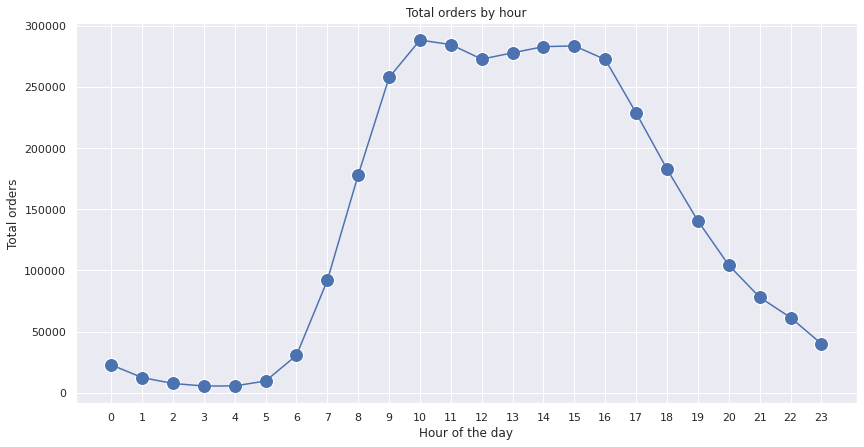

In [ ]:
sns.set(rc={"figure.figsize":(14,7)})
ax = sns.lineplot(x = "hour", y = "total_orders", data = res.toPandas())
ax = sns.scatterplot(x = "hour", y = "total_orders", marker = "o", s = 200, data = res.toPandas())
ax.set(title = "Total orders by hour", xlabel = "Hour of the day", ylabel = "Total orders");
ax.set_xticks(range(24)); #24 hours

▶ Below line graph shows that the customers are more likely to place an order between 9 am to 4 pm.

## How often do customers place orders?

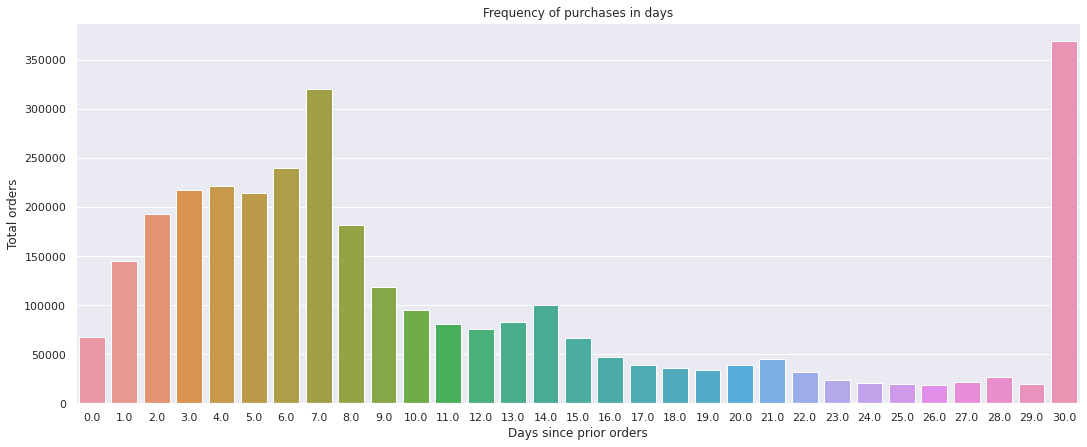

In [ ]:
query = """SELECT days_since_prior_order, COUNT(order_id) AS total_orders
           FROM orders 
           GROUP BY days_since_prior_order 
           ORDER BY days_since_prior_order"""

res = spark.sql(query)
sns.set(rc={"figure.figsize":(18,7)})
ax = sns.barplot(x = "days_since_prior_order", y = "total_orders", data = res.toPandas()); # null values not shown!
ax.set(title = "Frequency of purchases in days", xlabel = "Days since prior orders", ylabel = "Total orders");

▶ It appears that most of the customers order once a week since the majority of records are concentrated between 0 to 7 days

▶ Also, a large number of customer place their order 30 days or later days since because `days_since_prior` column is capped at 30.

# Advanced analysis

Let’s create a unique table by merging together products, departments, order_products_train, and order_products_prior datasets together and run the next queries on top of that.

With the inline query:

`SELECT * from order_products_train UNION SELECT * from order_products_prior`

we merge the order tables originally split for the challenge. We merge them to obtain all the order records.

In [ ]:
query = """(SELECT op.*, p.product_name, p.aisle_id, p.department_id, d.department FROM
                (SELECT * from order_products_train 
                 UNION
                 SELECT * from order_products_prior) AS op
            INNER JOIN products AS p
            ON op.product_id = p.product_id
            INNER JOIN departments AS d
            ON p.department_id = d.department_id)"""

res = spark.sql(query)
res.createOrReplaceTempView("master_table")

##How many items do customers purchase in an order?

In [ ]:
query = """SELECT order_id, count(product_id) AS total_items
           FROM master_table 
           GROUP BY order_id"""
res = spark.sql(query)
res.show()

+--------+-----------+
|order_id|total_items|
+--------+-----------+
|    6357|          9|
|   19204|         14|
|   91937|          5|
|  256425|          6|
|  310173|         15|
|  394664|          9|
|  401778|         15|
|  635824|          6|
|  649133|         45|
|  649345|         19|
|  806735|         31|
|  945360|          9|
| 1485259|          8|
| 1662500|          5|
| 1795417|         12|
| 2253413|          9|
| 2357326|          5|
| 2549981|         13|
| 2659807|         21|
| 2670527|         30|
+--------+-----------+
only showing top 20 rows



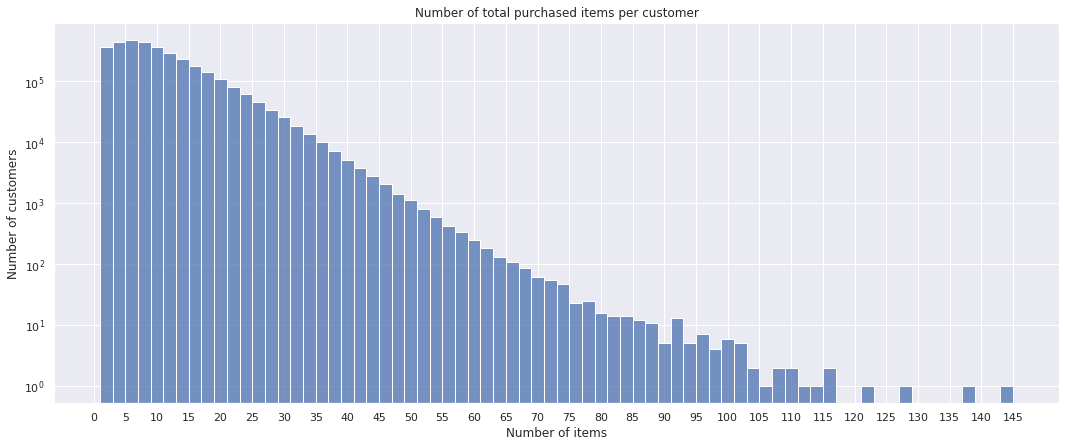

In [ ]:
sns.set(rc={"figure.figsize":(18,7)})
ax = sns.histplot(res.toPandas(), x = "total_items", binwidth = 2, log_scale = (False, True))
ax.set(title = "Number of total purchased items per customer", xlabel = "Number of items", ylabel = "Number of customers");
ax.set_xticks(range(0,150,5));

▶ The below bar chart depicts that the most common number of items purchased in order by customers seems to be between 5 and 7.

## Which are the top departments from which orders are placed?

In [ ]:
query = """SELECT department, COUNT(*) AS orders_count
           FROM master_table
           GROUP BY department
           ORDER BY orders_count DESC
           LIMIT 10"""

res = spark.sql(query)
res = res.toPandas()

The column `department` is set as index to properly plot the pie chart.

In [ ]:
res = res.set_index("department")
res

,orders_count
department,
produce,9888378
dairy eggs,5631067
snacks,3006412
beverages,2804175
frozen,2336858
pantry,1956819
bakery,1225181
canned goods,1114857
deli,1095540


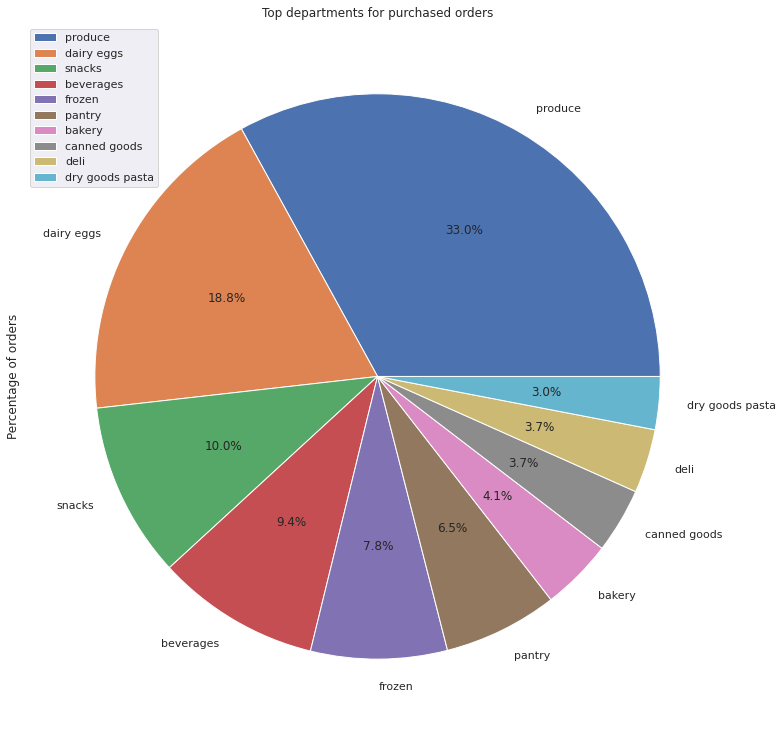

In [ ]:
pie = res.plot.pie(y = "orders_count", figsize = (13,13), autopct = "%1.1f%%")
pie.legend(loc = "upper left");
pie.set(title = "Top departments for purchased orders", ylabel = "Percentage of orders");

▶ If we take a look at top 10 departments from which most items are purchased, we would infer that almost 50% of the items purchased belong from just 2 departments which are ‘produce’ and ‘dairy eggs’.

## Which are the Top 10 most purchased items?

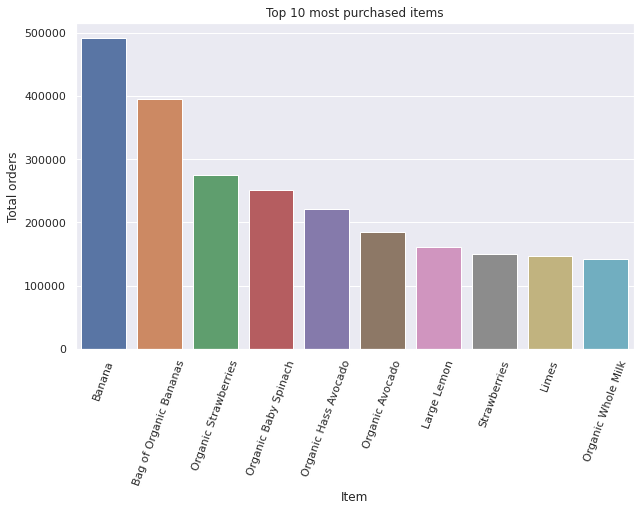

In [ ]:
query = """SELECT product_name, COUNT(*) AS orders_count
           FROM master_table
           GROUP BY product_name
           ORDER BY orders_count desc
           LIMIT 10"""
res = spark.sql(query)
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "product_name", y = "orders_count", data = res.toPandas())
ax.set(title = "Top 10 most purchased items", xlabel = "Item", ylabel = "Total orders")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

▶ These are the top 10 items bought by Instacart customers in their orders. Banana seems to be most bought commonly bought item in baskets followed by strawberries, baby spinach, avocado, etc.

## Word cloud of the top 200 items bought by Instacart customers

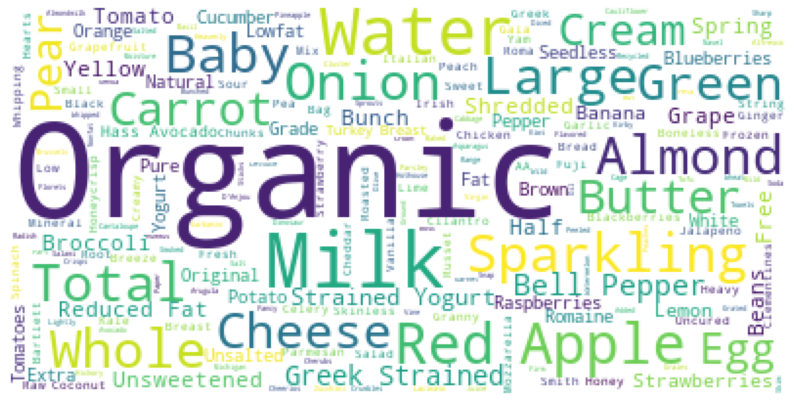

In [ ]:
df = spark.sql("""SELECT product_name
                  FROM (SELECT product_name, COUNT(*) AS orders_count 
                        FROM master_table
                        GROUP BY product_name
                        ORDER BY orders_count DESC
                        LIMIT 200)""")

# collecting and flattening the output
df2 = df.rdd.flatMap(lambda x : x).collect()
fullStr = ' '.join(df2)

# generating the wordcloud
wordcloud = WordCloud(background_color = "white").generate(fullStr)

# displaying the generated image
plt.figure(figsize = (14, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

From the word cloud, it appears that Americans buy organic food and veggies a lot as words like Organic, Milk, Water, Apple, Sparling, Egg, Green, Cheese, etc. are getting highlighted the most.

# Exercises: other two queries

Try to perform the following queries. Suggestions are provided.

## Compute the Top 10 Popular Items without master_table

In [ ]:
# possible SQL code here. Plot suggestion: bar plot.
select count(opp.order_id) as orders, p.product_name as popular_product
  from order_products_prior opp, products p
 where p.product_id = opp.product_id 
 group by popular_product 
 order by orders desc 
 limit 10

## Compute the Shelf Space taken by each Department

In [ ]:
# possible SQL code here. Plot suggestion: pie chart.
%sql
select d.department, count(distinct p.product_id) as products
  from products p
    inner join departments d
      on d.department_id = p.department_id
 group by d.department
 order by products desc
 limit 10

# FP-Growth Algorithm

We'll now use the FP-Growth algorithm. FP-growth is an improvement to the Apriori method since it generates frequent patterns without the need for candidate generation.

FP growth algorithm represents the database in the form of a tree called a frequent pattern tree or FP tree. This tree structure will maintain the association between the itemsets. The database is fragmented using one frequent item. This fragmented part is called “pattern fragment”. The itemsets of these fragmented patterns are analyzed. Thus with this method, the search for frequent itemsets is reduced comparatively.

Further info here: https://www.softwaretestinghelp.com/fp-growth-algorithm-data-mining/.


FP-growth leads two major improvements to the shortcomings of the Apriori Algorithm:

* Using Apriori needs a generation of candidate itemsets. These itemsets may be large in number if the itemset in the database is huge.

* Apriori needs multiple scans of the database to check the support of each itemset generated and this leads to high costs.

## Generation of baskets

For using FP-growth, first, we would be creating baskets of each order in our dataset.

We would do so by creating a baskets data frame having 2 columns: first, the order_id and second, the list of items bought in that particular order.

In [ ]:
from pyspark.sql.functions import collect_set

rawData = spark.sql("""SELECT p.product_name, o.order_id
                       FROM products p
                       INNER JOIN order_products_train o where o.product_id = p.product_id""")
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets.toPandas().head(5)

,order_id,items
0,1342,"[Raw Shrimp, Seedless Cucumbers, Versatile Sta..."
1,1591,"[Cracked Wheat, Strawberry Rhubarb Yoghurt, Or..."
2,4519,[Beet Apple Carrot Lemon Ginger Organic Cold P...
3,4935,[Vodka]
4,6357,"[Globe Eggplant, Panko Bread Crumbs, Fresh Moz..."


Above are the top 5 rows of the baskets data frame, to be fed into the FP-growth algorithm.

## Displaying of frequent itemsets, association rules and predictions

Here, we would be using spark.ml’s FP-growth package for implementation.

For FP-growth, no hyperparameter tuning is performed (you can try to perform it as an exercise, by using the prior orders table as validation/test set).

In [ ]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0)
model = fpGrowth.fit(baskets)

In [ ]:
# Display frequent itemsets.
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")
mostPopularItemInABasket.show()

# Display generated association rules.
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.show()

# transform examines the input items against all the association rules and summarize the consequents as prediction
associations = model.transform(baskets)
associations.show()

+--------------------+-----+
|               items| freq|
+--------------------+-----+
|[Organic Tomato B...|  772|
|[Organic Tomato B...|  175|
|[Organic Tomato B...|  144|
|[Organic Tomato B...|  179|
|[Organic Spinach ...|  475|
|[Whole Milk Ricot...|  347|
| [Medium Salsa Roja]|  275|
|    [Ground Buffalo]|  231|
|       [Tonic Water]|  194|
|[Original Coconut...|  173|
|[Low-Fat Strawber...|  152|
|[Organic SprouTof...|  137|
|            [Banana]|18726|
|[Fruit Punch Spor...|  275|
|[Kitchen Cheese E...|  230|
|[Country White Br...|  194|
|[Soft & Smooth Wh...|  173|
|[Natural Liquid L...|  152|
|[Bag of Organic B...|15480|
|[Organic Large Gr...|  769|
+--------------------+-----+
only showing top 20 rows

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+-------

## Most frequent basket of items (containing at least 2 items).

In [ ]:
query = """select items, freq
           from mostPopularItemInABasket
           where size(items) > 2
           order by freq desc
           limit 20"""
spark.sql(query).show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|[Organic Hass Avo...| 710|
|[Organic Raspberr...| 649|
|[Organic Baby Spi...| 587|
|[Organic Raspberr...| 531|
|[Organic Hass Avo...| 497|
|[Organic Avocado,...| 484|
|[Organic Avocado,...| 477|
|[Limes, Large Lem...| 452|
|[Organic Cucumber...| 424|
|[Limes, Organic A...| 389|
|[Organic Raspberr...| 381|
|[Organic Avocado,...| 379|
|[Organic Baby Spi...| 376|
|[Organic Blueberr...| 374|
|[Large Lemon, Org...| 371|
|[Organic Cucumber...| 366|
|[Organic Lemon, O...| 353|
|[Limes, Organic A...| 352|
|[Organic Whole Mi...| 339|
|[Organic Avocado,...| 334|
+--------------------+----+



The most frequent basket of items comprises of organic avocado, organic strawberries, and organic bananas together.

## Association rules

A good way to think about association rules is that model determines that if you purchased something (i.e. the antecedent), then you will purchase this other thing (i.e. the consequent) with the following confidence.

In [ ]:
query = """select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence
           from associationRules
           order by confidence desc
           limit 20"""

spark.sql(query).show()

+--------------------+--------------------+-------------------+
|     antecedent (if)|   consequent (then)|         confidence|
+--------------------+--------------------+-------------------+
|[Organic Raspberr...|[Bag of Organic B...| 0.5984251968503937|
|[Organic Cucumber...|[Bag of Organic B...|           0.546875|
|[Organic Kiwi, Or...|[Bag of Organic B...| 0.5459770114942529|
|[Organic Navel Or...|[Bag of Organic B...| 0.5412186379928315|
|[Yellow Onions, S...|            [Banana]| 0.5357142857142857|
|[Organic Whole St...|[Bag of Organic B...| 0.5314685314685315|
|[Organic Navel Or...|[Bag of Organic B...| 0.5283018867924528|
|[Organic Raspberr...|[Bag of Organic B...|  0.521099116781158|
|[Organic D'Anjou ...|[Bag of Organic B...| 0.5170454545454546|
|[Organic Unsweete...|[Bag of Organic B...| 0.5141065830721003|
|[Organic Broccoli...|[Bag of Organic B...| 0.5048231511254019|
|[Organic Lemon, O...|[Bag of Organic B...| 0.4989106753812636|
|[Organic Hass Avo...|[Bag of Organic B.

If a customer has organic raspberries, organic avocados, and organic strawberries in its basket, then it may make sense to recommend organic bananas as well.

Surprisingly, the top 10 purchase recommendations either organic bananas or bananas.